# Definitions of the initiation-to-initiation adder
Go to [Index](response_Witz2019_index.ipynb).

In this notebook we explain a confusion in the definition of the initiation-to-initiation adder $\delta_{ii}$ and of the initiation-to-division adder $\delta_{id}$, that emerged when studying the work of Witz and colleagues.

Denoting $\Lambda_i^{(n)}$ the cell size per origin of replication in the current generation $(n)$, we define the initiation-to-initiation adder as:
$$\delta_{ii} = \Lambda_{i}^{(n+1)} - \Lambda_{i}^{(n)}/2.$$

By constrast, Witz *et al.* defined it as:
$$\delta_{ii}^{b} = \Lambda_{i}^{(n)} - \Lambda_{i}^{(n-1)}/2,$$
where the superscript *b* stands for "backward". We call this the "backward" convention because the initiation-to-initiation adder terminates at the initiation event of the current generation. Therefore, from 2 overlapping cell-cycle onward, the initiation-to-initiation adder does not overlap with cell growth in the current generation.

A similar distinction can be made for the initiation-to-division adder $\delta_{id} = S_d^{(n)} - \Lambda_i^{(n)}$. It is important however that both adders start at the same initiation event, *i.e.* associated with the correct cell size per origin of replication, either $\Lambda_i^{(n)}$ or $\Lambda_i^{(n-1)}$ for both.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['svg.fonttype'] = 'none'   # to export text as text, not curves
from IPython.display import Image

import sys
sys.path.append('code')
from functions_response import make_binning_edges, get_binned, process_gw

In [3]:
ext_list = ['.png','.svg']
# create/declare export directory for figures
fig_dir = os.path.join('figures','definitions_delta_ii_delta_id')
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

## Data exported for figures 1, 2, 3 and 5

In the notebook [data_aggregation](../DataProcessing/data_aggregation.ipynb), it appears that the initiation-to-initiation adder is computed as follows:
> m.at[x,'DLi'] = m.at[x,'Li_fit']-0.5*m.at[m.at[x,'mother_id'],'Li_fit'],
>
> m.at[x,'Li_old'] = 0.5*m.at[m.at[x,'mother_id'],'Li_fit'],

or in other words, with our notations:
$$\delta_{ii}^{b} = \Lambda_{i}^{(n)} - \Lambda_{i}^{(n-1)}/2,$$
hence the "backward" convention was used.

In the notebook [dataset_fig_1_2_3](../GatherData/dataset_fig_1_2_3.ipynb), the processed experimental data is directly read to make the figures 1, 2 and 3 of Witz *et al.* paper. In particular, we see how the initiation-to-division adder is defined:
> colidata[i]['DLdLi'] = colidata[i]['Ld_fit']-colidata[i]['Li_fit'],

consistent with the definition of $\delta_{id}$ given above. Finally, we note that it is eventually renamed as `dLambda_ib`:
>colidata_export = colidata_export.rename(columns = {'Lb_fit': 'Lb', 'DeltaL':'dL','Li_fit':'Li','Li_old':'Li_prev',
                        'DLi':'dLambda_if','tau_fit':'lambda_inv','Tdi':'Tid','DLdLi':'dLambda_ib','mLb_fit':'Lb_mother'.
                        
                        
In the notebook [figure_1_2_3](../Plotting/figure_1_2_3.ipynb), figures 1 to 3 are made. We note in particular that Figure 3B used the following variables:
> varx = 'Li_prev'
>
> vary = 'dLambda_ib',

meaning that it is a plot of $\delta_{id}^{(n)} = S_d^{(n)} - \Lambda_i^{(n)}$ versus $\Lambda_i^{(n-1)}$. We believe that comparing $\delta_{id}^{(n)}$ to $\Lambda_i^{(n)}$ would probably have been more adequate.

Below we show that when plotting $\delta_{id}^{(n)}$ versus $\Lambda_i^{(n)}$, a slight negative correlation appears.

In [4]:
fpath=os.path.join('..','Data_export','Fig1_2_3.csv')
df_export = pd.read_csv(fpath)

df_export['lambda'] = np.log(2.)/df_export['lambda_inv']*60
df_export['Ld'] = df_export['Lb'] + df_export['dL']
names = df_export['condition'].unique().tolist()

In [5]:
binw=0.05
colors = ['purple', 'green', 'orange']
fields = ['Li', 'Li_prev']
nfield = len(fields)
xlabels = ['$\Lambda_i / \langle \Lambda_i \\rangle$', '$\Lambda_i^{(n-1)} / \langle \Lambda_i^{(n-1)}\\rangle$']
ylabel = '$\delta_{id} / / \langle \delta_{id} \\rangle $'


fig = plt.figure(constrained_layout=True, figsize=(4*nfield,4))
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

axes = []
ax = fig.add_subplot(gs[0,0])
axes.append(ax)
for i in range(1,nfield):
    ax = fig.add_subplot(gs[0,i], sharey=axes[0])
    axes.append(ax)
    
for k,field in enumerate(fields):
    ax = axes[k]
    xlabel = xlabels[k]
    for n,name in enumerate(names):
        color = colors[n]
        idx = df_export['condition'] == name
        
        X, Y = df_export.loc[idx, [field,'dLambda_ib']].dropna().to_numpy().astype('float64').T

        m = np.mean(X)
        X /= m
        m = np.mean(Y)
        Y /= m
        edges = make_binning_edges(X, x0=None, x1=None, binw=binw)
        X_binned = 0.5*(edges[:-1] + edges[1:])
        nbins = len(edges)-1

        Y_binned_sets = get_binned(X,Y,edges)
        Y_binned = np.zeros(nbins)
        Y_counts = np.zeros(nbins)
        Y_vars = np.zeros(nbins)

        for i in range(nbins):
            Yi = Y_binned_sets[i]
            Zi = np.nansum(np.isfinite(Yi),axis=0)
            if (Zi == 0):
                continue
            m = np.nansum(Yi,axis=0) / Zi
            v = np.nansum((Yi-m)**2,axis=0) / Zi
            Y_counts[i] = Zi
            Y_binned[i] = m
            Y_vars[i] = v
        idx = np.isfinite(Y_counts) & (Y_counts > 12)
        X_binned = X_binned[idx]
        Y_binned = Y_binned[idx]
        Y_binned_err = np.sqrt(Y_vars[idx]/Y_counts[idx])

        ax.errorbar(X_binned, Y_binned, yerr=Y_binned_err, color=color, linestyle='none', marker='s', ms=4, ecolor=color, elinewidth=1, lw=0.5, label=name)
        
        # end loop on conditions

        ax.set_xlabel(xlabel, fontsize='medium')
        if (k == 0):
            ax.set_ylabel(ylabel, fontsize='medium')
        if (k == nfield - 1):
            ax.legend(loc='best', fontsize='medium')
    ax.set_aspect('equal')
    ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
    ax.tick_params(axis='both', which='both', length=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_smart_bounds(True)
#     ax.spines['bottom'].set_smart_bounds(True)


gs.tight_layout(fig)


fpath = os.path.join(fig_dir,'fig3B')
for ext in ext_list:
    fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
    print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
plt.close('all')

Saved figure in figures/definitions_delta_ii_delta_id/fig3B.png
Saved figure in figures/definitions_delta_ii_delta_id/fig3B.svg


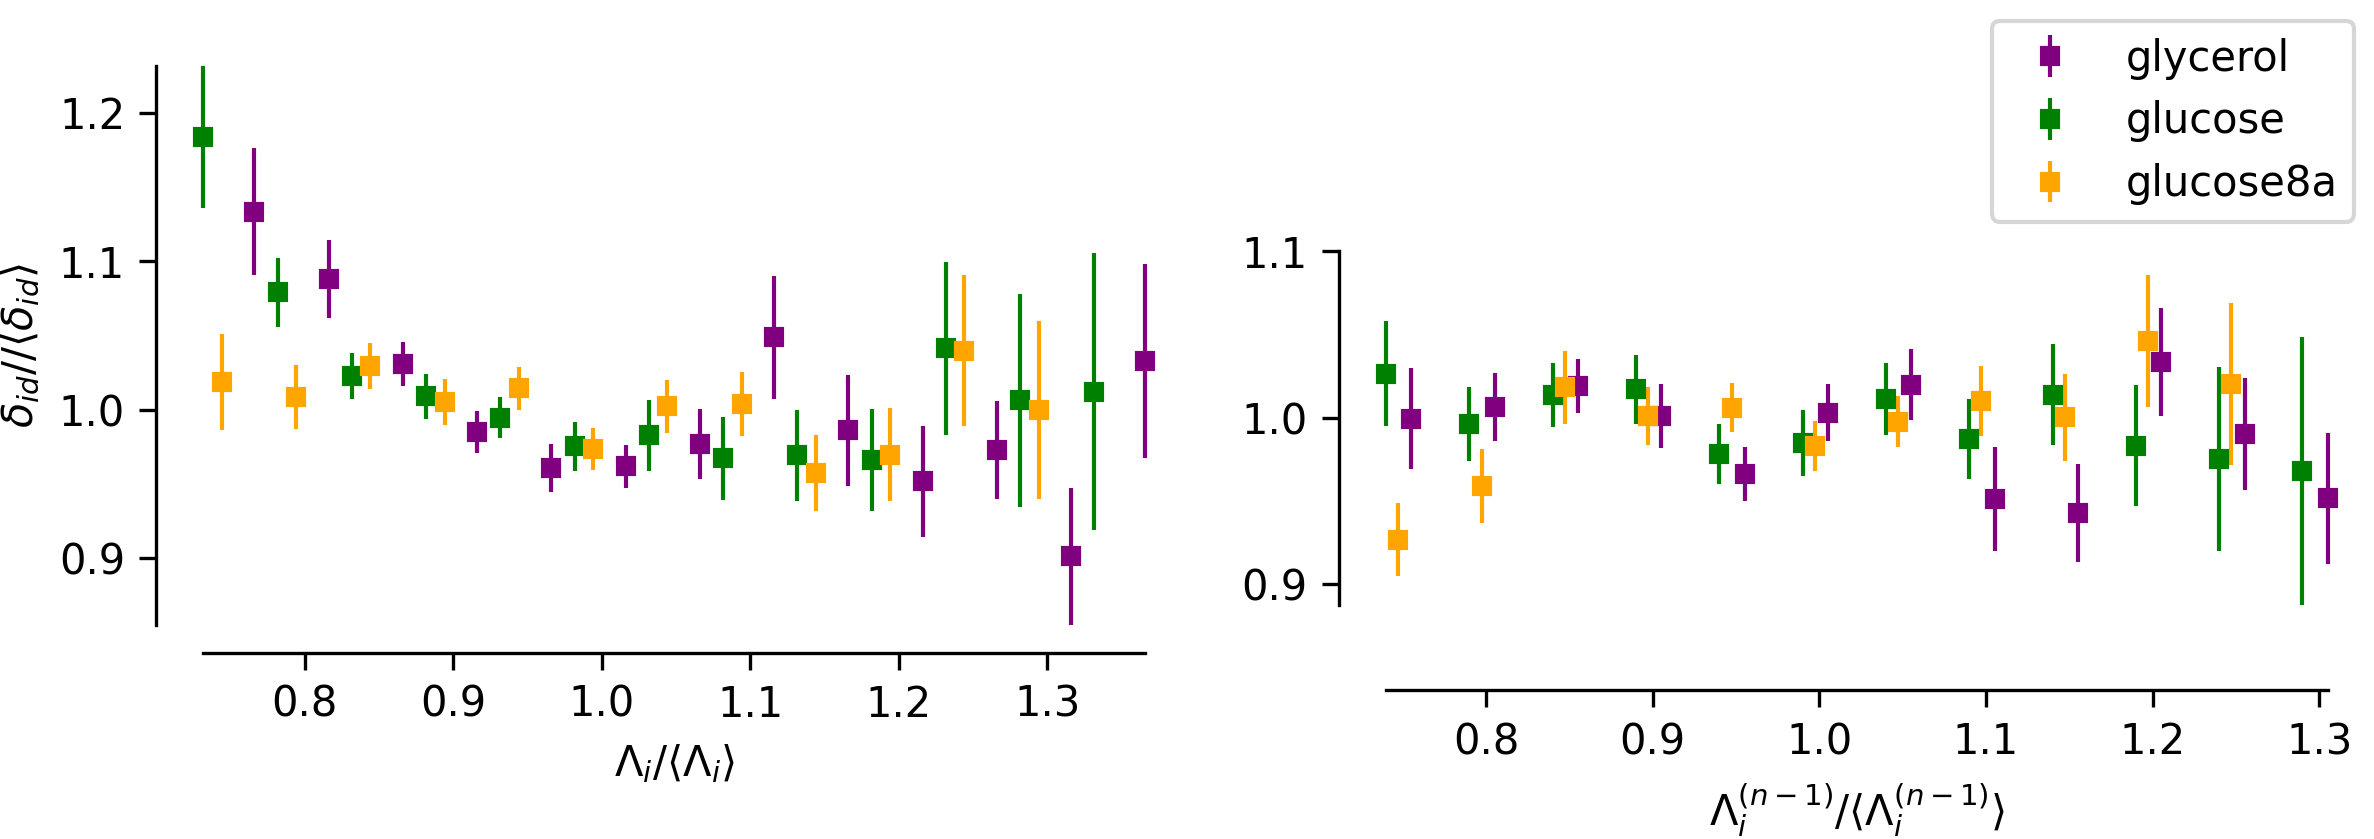

In [6]:
fpath = os.path.join(fig_dir,"fig3B.png")
# display one of the previous figures
Image(filename=fpath) 

Below we show that the conventions that we used in the determinant analysis presented in [response_Witz2019_determinant_analysis](response_Witz2019_determinant_analysis.ipynb) are consistent with the "forward" definitions. We directly compare our computed values of the initiation-to-initiation and initiation-to-division adders with the data introduced above.

In [7]:
# parameters
mapping_dict = {'glycerol': { \
                             'dir': '20180706_GW296_glycerol37_1_MMStack',
                            }, 
                'glucose': { \
                           'dir': '20180711_GW296_glucose37_1_MMStack', \
                           },
                'glucose8a': { \
                               'dir': '20180709_GW296_glucose8aa37_1_MMStack', \
                              }
            }
size_scale = 0.065 # nm/px
time_scale = 3 # min / frame
size_columns = ['length', 'Lb', 'Lb_fit', 'Ld_fit', 'Ld', 'Li', 'Li_fit', 'DLi', 'Li_old']

# import Witz et al datasets
mydir = os.path.join('.','experiments')
decs = 4
df_dict = {}
for name in names:
    fpath = os.path.join('..','PreProcessed', mapping_dict[name]['dir'], 'colidata.pkl')
    print(name, fpath)
    
    colidata = pd.read_pickle(fpath)

    # rescale size
    func = lambda x: x*size_scale
    colidata[size_columns] = colidata[size_columns].apply(func)
    
    # remove cells without enough data points
    func = lambda x:  len(x) < 2
    idx = colidata['length'].apply(func)
    colidata.drop(colidata.index[idx], axis=0, inplace=True)
    
    # process data
    process_gw(colidata, time_scale, fitting=True)   # we apply the fitting method as in Witz et al's work
    
    # correct the factor of 2 (definition)
    colidata['delta_id'] = 2*colidata['delta_id']

    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                }
    
    colidata.rename(columns=col_mapping, inplace=True)
    colidata['lambda'] = 60.*colidata['lambda']
    
    df_dict[name] = colidata

glycerol ../PreProcessed/20180706_GW296_glycerol37_1_MMStack/colidata.pkl
Using fitted dimensions...
glucose ../PreProcessed/20180711_GW296_glucose37_1_MMStack/colidata.pkl
Using fitted dimensions...
glucose8a ../PreProcessed/20180709_GW296_glucose8aa37_1_MMStack/colidata.pkl
Using fitted dimensions...


In [8]:
couples = []
couples.append(['lambda', 'lambda'])
# check lambda_not fitted versus their lambda: should be exactly the same.
couples.append(['lambda_inv', 'tau_eff'])
couples.append(['Lb', 'Sb'])
couples.append(['Ld', 'Sd'])
couples.append(['Li', 'Lambda_i'])
couples.append(['dLambda_if', 'delta_ii_backward'])
couples.append(['dLambda_if', 'delta_ii'])
couples.append(['dLambda_ib', 'delta_id'])


for name in names:
    # select same cells for both data frames
    dfgw = df_export.loc[df_export['condition'] == name].round(decs)
    dfslt = df_dict[name].round(decs)

    setgw = set(dfgw['lambda_inv'].dropna().unique().tolist())
    setslt = set(dfslt['tau_eff'].dropna().unique().tolist())
    selection = list(setgw.intersection(setslt))
    print("Found a data intersection base on lambda_inv of {:d} points".format(len(selection)))

    idx = dfgw['lambda_inv'].isin(selection)
    dfgw = dfgw[idx]
    idx = dfslt['tau_eff'].isin(selection)
    dfslt = dfslt[idx]

    # make plot
    nplots = len(couples)
    nrows = int(np.sqrt(nplots))
    ncols = int(nplots / nrows)
    if nrows*ncols < nplots:
        ncols += 1

    fig = plt.figure(constrained_layout=True, figsize=(ncols*3, nrows*3))
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    axes = []
    for n in range(nplots):
        i = int(n/ncols)
        j = n - i*ncols
        ax = fig.add_subplot(gs[i,j])
        axes.append(ax)
        c1,c2 = couples[n]
        X = dfgw[c1].to_numpy().astype('float64')
        Y = dfslt[c2].to_numpy().astype('float64')
        xmin = min(np.nanmin(X), np.nanmin(Y))
        xmax = max(np.nanmax(X), np.nanmax(Y))
        ax.plot(X,Y,'bo', ms=1)
        ax.plot([xmin,xmax],[xmin,xmax], 'k--', lw=0.5)
        ax.set_xlabel(c1, fontsize='medium')
        ax.set_ylabel(c2, fontsize='medium')
        ax.set_aspect('equal')
        ax.tick_params(bottom=True, left=True, labelbottom=True, labelleft=True)
        ax.tick_params(axis='both', which='major', length=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_aspect('equal')

    fig.suptitle('Condition: {:s}'.format(name))
    gs.tight_layout(fig)

    fpath = os.path.join(fig_dir,name)
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
    #     fig.clf()
    plt.close('all')

Found a data intersection base on lambda_inv of 845 points
Saved figure in figures/definitions_delta_ii_delta_id/glycerol.png
Saved figure in figures/definitions_delta_ii_delta_id/glycerol.svg
Found a data intersection base on lambda_inv of 1061 points
Saved figure in figures/definitions_delta_ii_delta_id/glucose.png
Saved figure in figures/definitions_delta_ii_delta_id/glucose.svg
Found a data intersection base on lambda_inv of 1211 points
Saved figure in figures/definitions_delta_ii_delta_id/glucose8a.png
Saved figure in figures/definitions_delta_ii_delta_id/glucose8a.svg


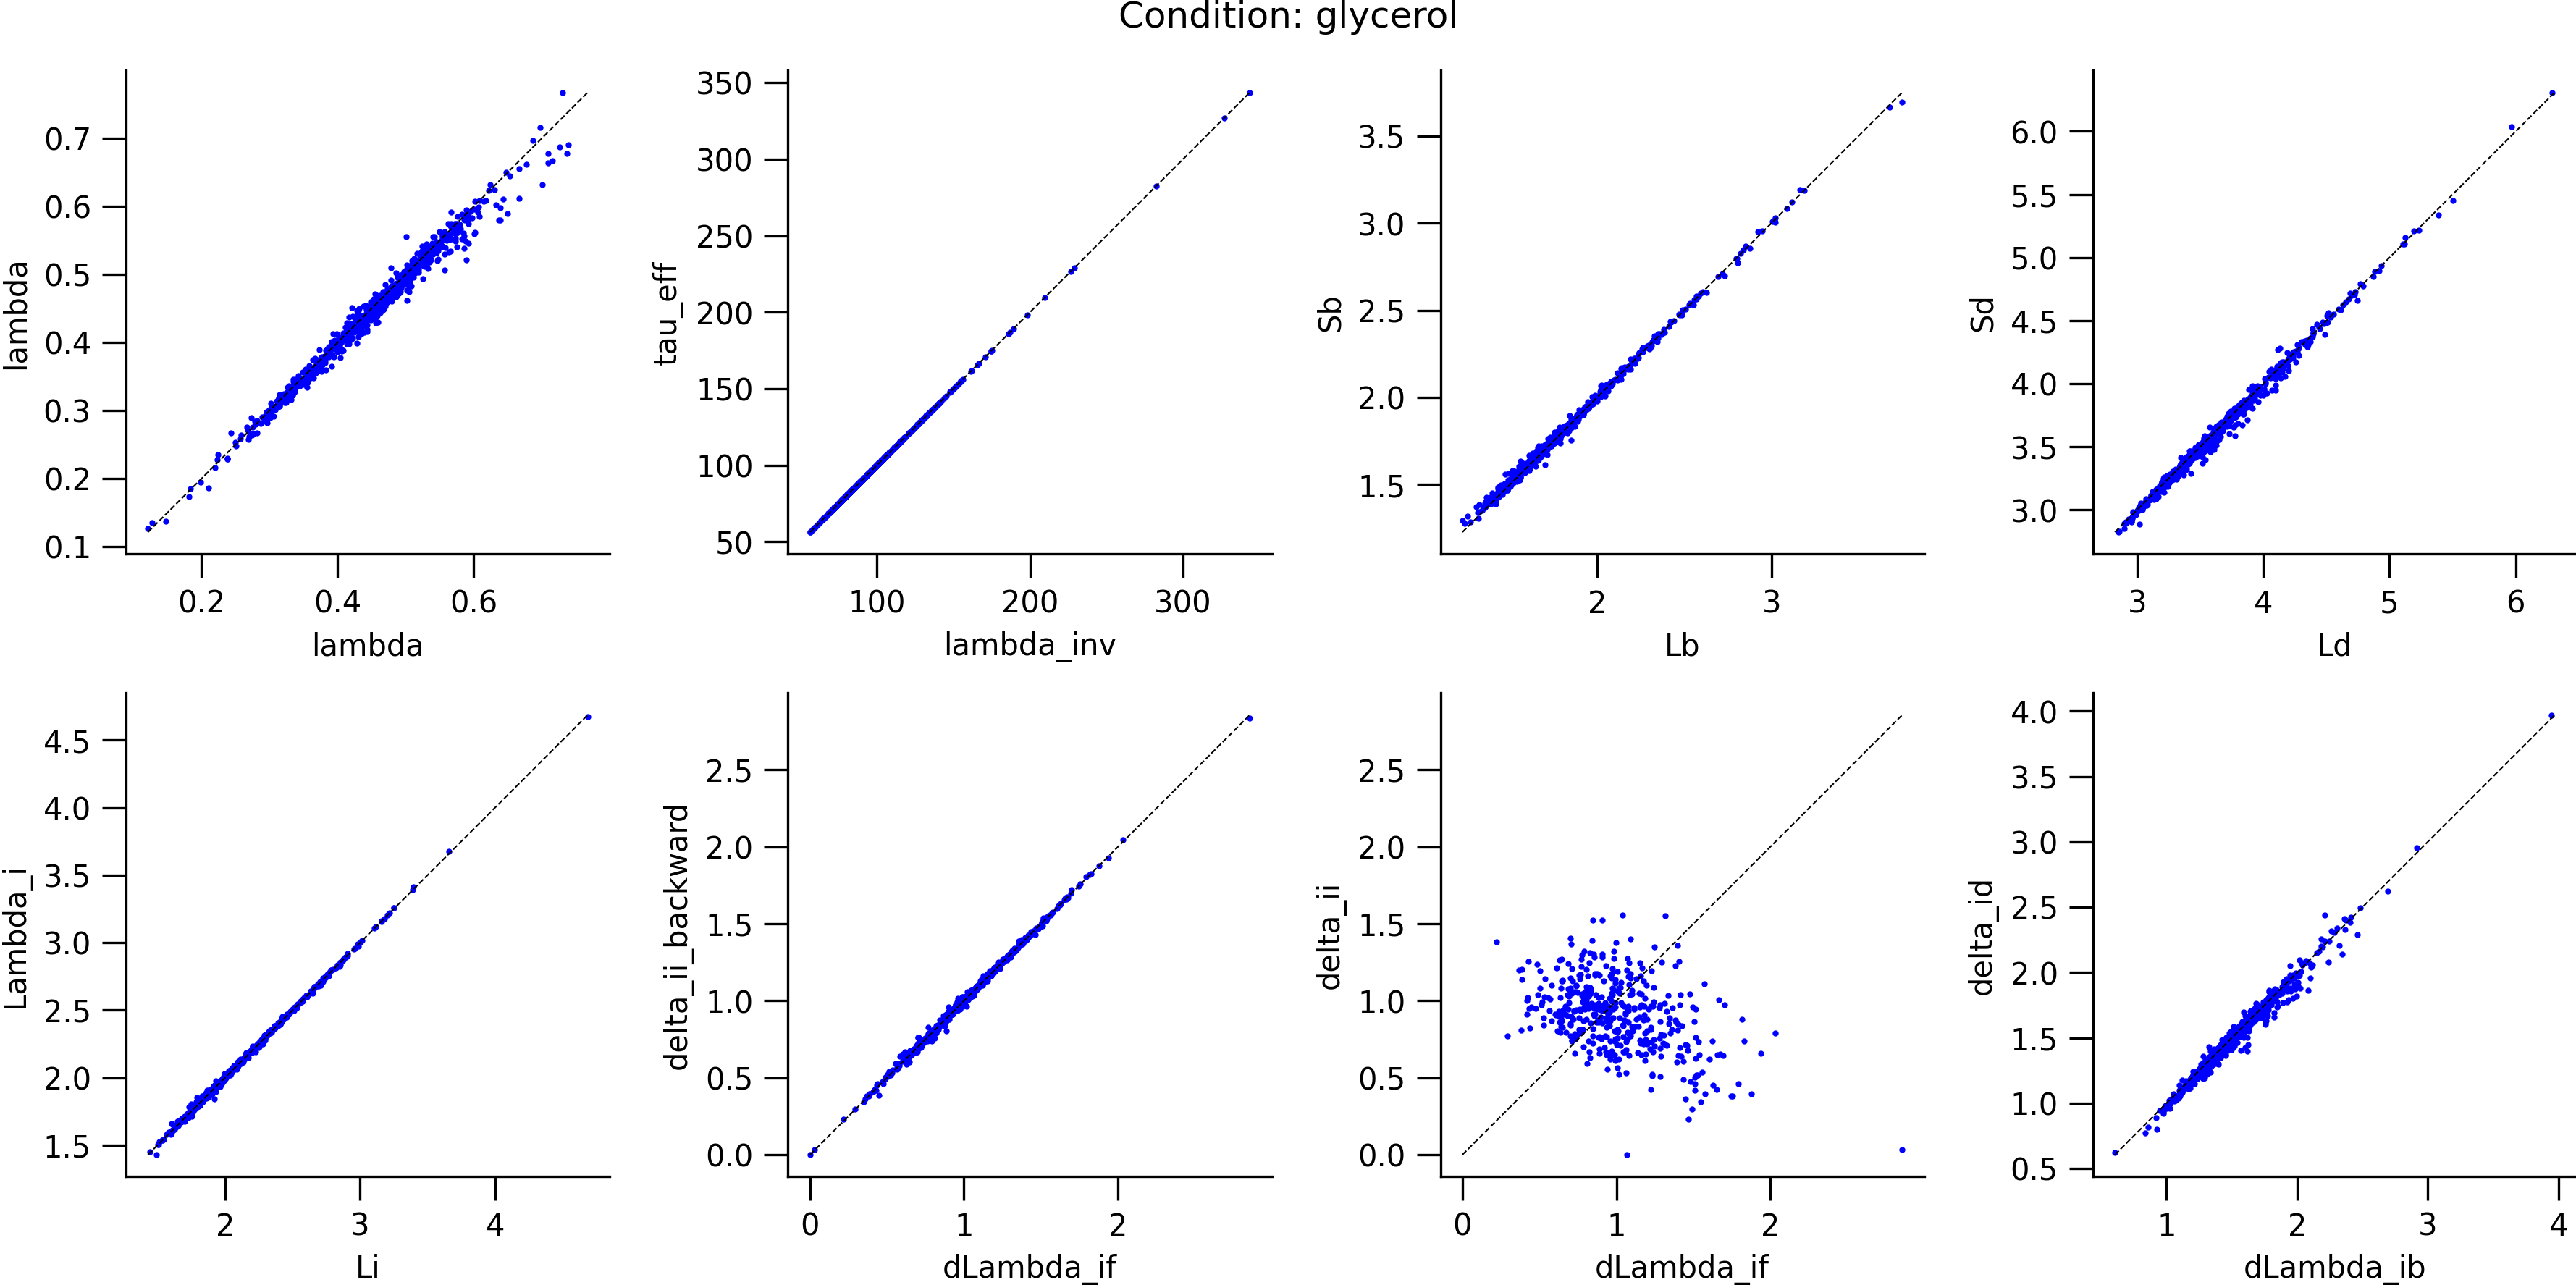

In [9]:
name = 'glycerol'
fpath = os.path.join(fig_dir,"{:s}{:s}".format(name,'.png'))
# display one of the previous figures
Image(filename=fpath) 

It is therefore clear that the values given by Witz et al for the initiation adder are in agreement with the "backward" definition whereas the values given for the "initiation-to-division" adder are in agreement with the "forward" convention.

## Computation for figure 7

The computation of the I-values presented in Figure 7 from Witz and colleagues is detailed in [figure_7B](../Plotting/figure_7B.ipynb). From the same processed data, the initiation-to-initiation and initiation-to-division adder are this time computed through the method:
>colidata_exp = dp.cross_generation_construct(colidata_exp, 'exp', time_scale = 3).


The method `cross_generation_construct` is defined in the file [decomposition.py](../colicycle/colicycle/decomposition.py). The correspondence with the variables $\Lambda_i$, $\Lambda_f$, $\mathrm{d}\Lambda_{if}$ and $\mathrm{d}\Lambda_{ib}$ used by Witz and colleagues' notation for the initiation-centric variables can be seen in the method `renaming_modelGW`. The initiation-to-initiation adder is here computed as:
>colidata.loc[:,'DeltaLgi']= colidata['Lig2_fit']-colidata['Lig_fit'],

or with our notations:
$$\delta_{ii}^{b} = \Lambda_{i}^{(n)} - \Lambda_{i}^{(n-1)}/2.$$

Therefore, once again the "backward" convention is used.

The initiation-to-division adder for the initiation-centric variable is computed as:
>colidata.loc[:,'DeltaLigb'] = 0.5*colidata.apply(lambda row: tmo.mother_var(row, colidata,'DeltaLid'),axis = 1).

or with our notations:
$$
\delta_{id}^{b} = \frac{\delta_{id}^{(n-1)}}{2} = \frac{S_d^{(n-1)} - \Lambda_i^{(n-1)}}{2}.
$$

Therefore, for the determinant analysis, the initiation-to-division adder was computed using a "backward" convention instead. Both adders start at the same replication initiation event.
